In [12]:
from tqdm.auto import tqdm
from tqdm import tqdm
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
import os

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [3]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==20:
    target='DELV120'
if int(config_set['target_lag'])==16:
    target='DELV96'
if int(config_set['target_lag'])==12:
    target='DELV72'
if int(config_set['target_lag'])==8:
    target='DELV48'
if int(config_set['target_lag'])==4:
    target='DELV24'
seeds = np.arange(0,7,1)#np.arange(100,131,1)

In [5]:
seeds = np.arange(0,7,1)
var_names = performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='shipsnew').read_stored()['var_names']

In [6]:
target

'DELV24'

In [7]:
def pearson_corr(measureds, estimations):
    # Calculate the Pearson correlation coefficient
    corr = pearsonr(measureds, estimations)
    return corr.statistic

In [8]:
list(var_names)

['DELV24',
 'T200',
 'T250',
 'LAT',
 'CSST',
 'PSLV',
 'Z850',
 'D200',
 'EPOS',
 'SHDC',
 'RHMD',
 'TWAC',
 'G200',
 'TADV',
 'SHGC',
 'POT',
 'POT2',
 'LHRD',
 'VSHR',
 'PER',
 'VPER',
 'R001',
 'R000',
 'SHMD',
 'PVOR',
 'SHL1',
 'SHL0',
 'pc20']

# No causal selection

In [13]:
score_nocausal = []
for seed in tqdm(seeds):
    nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsnew').run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

pcc_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2_from_pcc'] for i in range(len(score_nocausal))]

r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]


00%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.37it/s]

#### results

In [14]:
np.asarray(r2_train_noFS).max(),np.asarray(r2_valid_noFS).max(),np.asarray(r2_test_noFS).max()

(0.21136690761054466, 0.1850642982594296, 0.19520693754883045)

In [15]:
np.asarray(r2_train_noFS).min(),np.asarray(r2_valid_noFS).min(),np.asarray(r2_test_noFS).min()

(0.1943937534986886, 0.07587990432825698, 0.17972163441125477)

In [16]:
np.asarray(r2_train_noFS).mean(),np.asarray(r2_valid_noFS).mean(),np.asarray(r2_test_noFS).mean()

(0.19827971147344434, 0.15504233041008253, 0.18867185262816427)

In [17]:
np.asarray(pcc_train_noFS).max(),np.asarray(pcc_valid_noFS).max(),np.asarray(pcc_test_noFS).max()

(0.2113669076105447, 0.1889164329958083, 0.19690572281496438)

In [18]:
np.asarray(pcc_train_noFS).min(),np.asarray(pcc_valid_noFS).min(),np.asarray(pcc_test_noFS).min()

(0.19439375349868854, 0.08958064658182296, 0.18071299725877393)

In [19]:
np.asarray(pcc_train_noFS).mean(),np.asarray(pcc_valid_noFS).mean(),np.asarray(pcc_test_noFS).mean()

(0.19827971147344434, 0.16401324388879446, 0.18998405157810255)

# With causal

In [20]:
import importlib
importlib.reload(performance_scores)

<module 'util.models.performance_scores' from '/home/upendra/test/2025_CausalSHIPS/util/models/performance_scores.py'>

In [22]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsnew').run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])

pcc_train_causalFS, pcc_valid_causalFS, pcc_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    pcc_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])


00%|█████████████████████████████████████████████| 7/7 [01:43<00:00, 14.75s/it]

In [23]:
bestfold_causal = np.asarray([np.mean(obj) for obj in pcc_valid_causalFS]).argmax()
bestmodel_causal = [np.argmax(obj) for obj in pcc_valid_causalFS][bestfold_causal]
print(bestfold_causal,bestmodel_causal)

3 14


### Explore 24hr
The SHIPS-enhanced models were better than the SHIPS-original version for most cases, so now we take a look at whether the additional variables are chosen, i.e., whether or not the causal models are better because of the new variables.

In [28]:
bestfold = np.asarray([np.mean(obj) for obj in pcc_valid_causalFS]).argmax()
bestmodel = [np.argmax(obj) for obj in pcc_valid_causalFS][bestfold]
resultsz = miss.read_pickle('results/'+str(int(config_set['target_lag']))+'/'+'shipsnew'+'/'+'results_fold_'+str(int(seeds[bestfold]))+'.pkl')['PC1_results']
[var_names[ind] for ind in [obj[0] for obj in resultsz[bestmodel][0]]]

['POT', 'PSLV', 'SHL1', 'G200', 'T200', 'SHMD', 'PVOR']

##### results

In [29]:
np.asarray(miss.flatten(r2_train_causalFS)).max(),np.asarray(miss.flatten(r2_valid_causalFS)).max(),np.asarray(miss.flatten(r2_test_causalFS)).max()

(0.20775012710254837, 0.2114984112249113, 0.18881848862723294)

In [30]:
np.asarray(miss.flatten(r2_train_causalFS)).min(),np.asarray(miss.flatten(r2_valid_causalFS)).min(),np.asarray(miss.flatten(r2_test_causalFS)).min()

(0.15917012991688195, 0.07232879746524168, 0.1310653647900759)

In [31]:
np.asarray(miss.flatten(r2_train_causalFS)).mean(),np.asarray(miss.flatten(r2_valid_causalFS)).mean(),np.asarray(miss.flatten(r2_test_causalFS)).mean()

(0.1838092234857338, 0.16572339057578456, 0.16906050614747964)

In [32]:
np.asarray(miss.flatten(pcc_train_causalFS)).max(),np.asarray(miss.flatten(pcc_valid_causalFS)).max(),np.asarray(miss.flatten(pcc_test_causalFS)).max()

(0.20775012710254848, 0.21643980056631867, 0.19002044313140717)

In [33]:
np.asarray(miss.flatten(pcc_train_causalFS)).min(),np.asarray(miss.flatten(pcc_valid_causalFS)).min(),np.asarray(miss.flatten(pcc_test_causalFS)).min()

(0.159170129916882, 0.08532277640276034, 0.133693060448356)

In [34]:
np.asarray(miss.flatten(pcc_train_causalFS)).mean(),np.asarray(miss.flatten(pcc_valid_causalFS)).mean(),np.asarray(miss.flatten(pcc_test_causalFS)).mean()

(0.18380922348573384, 0.17190739021483634, 0.1702840860678214)

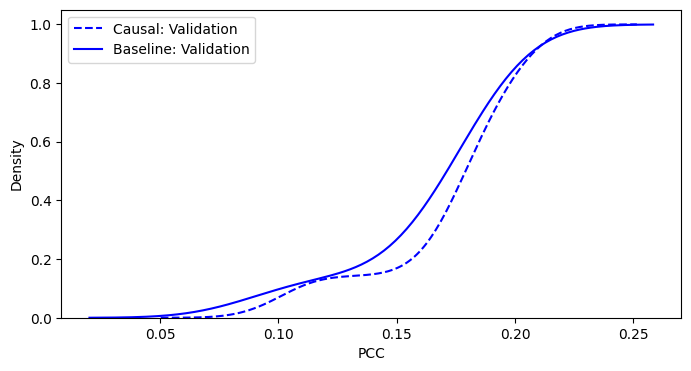

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
#sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',c='k',label='Causal: Train',ax=ax)
#sns.kdeplot((r2_train_noFS),c='k',ls='-',label='Baseline: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',c='b',label='Causal: Validation',ax=ax,cumulative=True)
sns.kdeplot((pcc_valid_noFS),c='b',ls='-',label='Baseline: Validation',ax=ax,cumulative=True)
#sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',c='r',label='Causal: Test',ax=ax,cumulative=True)
#sns.kdeplot((r2_test_noFS),c='r',ls='-',label='Baseline: Test',ax=ax,cumulative=True)
plt.legend(loc=2)
plt.xlabel('PCC')
#plt.xlim(-6,6)
plt.savefig(f'./figures/SHIPSplus_kfold_pcc_{target}.png',dpi=600)
plt.show()

## With Correlation

In [36]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,
                                                          lag=int(config_set['target_lag']),exp='shipsnew').run_score_corrFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)

pcc_train_corrFS, pcc_valid_corrFS, pcc_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_corrFS.append(trains)
    pcc_valid_corrFS.append(valids)
    pcc_test_corrFS.append(tests)


00%|█████████████████████████████████████████████| 7/7 [00:54<00:00,  7.74s/it]

In [37]:
len(score_correlation[2]['scoreboard'])

13

In [38]:
bestfold_corr = np.asarray([np.mean(obj) for obj in pcc_valid_corrFS]).argmax()
bestmodel_corr = [np.argmax(obj) for obj in pcc_valid_corrFS][bestfold_corr]

In [39]:
bestfold_corr, bestmodel_corr

(2, 6)

In [40]:
bestfold_corr = np.asarray([np.mean(obj) for obj in pcc_valid_corrFS]).argmax()
bestmodel_corr = [np.argmax(obj) for obj in pcc_valid_corrFS][bestfold_corr]
resultsz_corr = score_correlation[bestfold_corr]
resultsz_corr['corrrank'][:bestmodel_corr]

T200    0.173257
T250    0.083364
LAT     0.158955
CSST    0.002647
PSLV    0.113456
Z850    0.034012
dtype: float64

##### results

In [41]:
np.asarray(miss.flatten(r2_train_corrFS)).max(),np.asarray(miss.flatten(r2_valid_corrFS)).max(),np.asarray(miss.flatten(r2_test_corrFS)).max()

(0.20292683222601526, 0.22321134468544923, 0.17956508357167578)

In [42]:
np.asarray(miss.flatten(r2_train_corrFS)).min(),np.asarray(miss.flatten(r2_valid_corrFS)).min(),np.asarray(miss.flatten(r2_test_corrFS)).min()

(0.14440233861416474, 0.07897354272405943, 0.11549444716464108)

In [43]:
np.asarray(miss.flatten(r2_train_corrFS)).mean(),np.asarray(miss.flatten(r2_valid_corrFS)).mean(),np.asarray(miss.flatten(r2_test_corrFS)).mean()

(0.17080834403451617, 0.15751691864081024, 0.14384284693812016)

In [44]:
np.asarray(miss.flatten(pcc_train_corrFS)).max(),np.asarray(miss.flatten(pcc_valid_corrFS)).max(),np.asarray(miss.flatten(pcc_test_corrFS)).max()

(0.20292683222601524, 0.2301101224266915, 0.18247687542023014)

In [45]:
np.asarray(miss.flatten(pcc_train_corrFS)).min(),np.asarray(miss.flatten(pcc_valid_corrFS)).min(),np.asarray(miss.flatten(pcc_test_corrFS)).min()

(0.1444023386141648, 0.08553603257867641, 0.11720913024728769)

In [46]:
np.asarray(miss.flatten(pcc_train_corrFS)).mean(),np.asarray(miss.flatten(pcc_valid_corrFS)).mean(),np.asarray(miss.flatten(pcc_test_corrFS)).mean()

(0.17080834403451617, 0.16409979350609205, 0.14491324742791484)

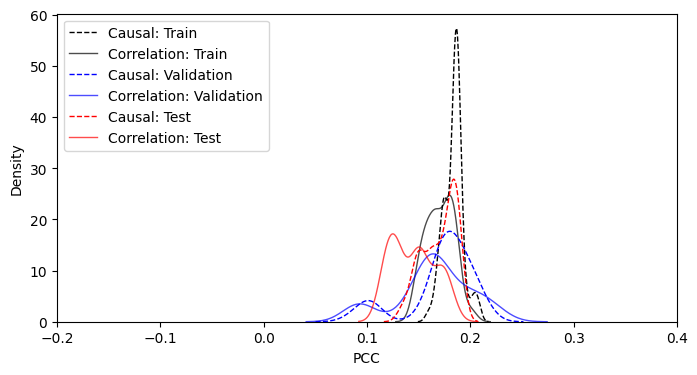

In [47]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(np.asarray(miss.flatten(pcc_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_train_corrFS)),c='k',ls='-',lw=1,alpha=0.7,label='Correlation: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_corrFS)),c='b',ls='-',lw=1,alpha=0.7,label='Correlation: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_corrFS)),c='r',ls='-',lw=1,alpha=0.7,label='Correlation: Test',ax=ax)
plt.legend(loc=2)
plt.xlabel('PCC')
plt.xlim(-0.2,0.4)
plt.savefig(f'./figures/SHIPSplus_noassum_pcc_corr_kfold_{target}.png',dpi=600)
plt.show()

In [48]:
import importlib
importlib.reload(performance_scores)

<module 'util.models.performance_scores' from '/home/upendra/test/2025_CausalSHIPS/util/models/performance_scores.py'>

## With XAI feature selection

In [50]:
# Define the directory where the pickle files will be stored
import os
save_dir = 'results/4/XAI_shipsplus/'

# Ensure the directory exists, if not, create it
os.makedirs(save_dir, exist_ok=True)

score_corr = []
for seed in tqdm(seeds):
    corr_results = performance_scores.scores_seeds(seed=seed, target=target, lag=int(config_set['target_lag']), exp='shipsnew').run_score_XAIFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    
    # Save the result to a pickle file for each seed with the specified path
    save_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(corr_results, f)
    
    score_corr.append(corr_results)
    del corr_results
    gc.collect()



00%|█████████████████████████████████████████████| 7/7 [04:41<00:00, 40.22s/it]

In [51]:
(int(config_set['target_lag']))

4

In [53]:
#save_dir= '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/ships_plus_new/results/20/XAI_shipsplus/'
save_dir = f"results/{(int(config_set['target_lag']))}/XAI_shipsplus/"
# List to store the loaded results
score_corr = []

# Load each pickle file and append to score_corr
for seed in seeds:
    file_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(file_path, 'rb') as f:
        corr_results = pickle.load(f)
        score_corr.append(corr_results)

r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

pcc_train_XAIFS, pcc_valid_XAIFS, pcc_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_XAIFS.append(trains)
    pcc_valid_XAIFS.append(valids)
    pcc_test_XAIFS.append(tests)

In [55]:
bestfold_xai = np.asarray([np.mean(obj) for obj in pcc_valid_XAIFS]).argmin()
bestmodel_xai = [np.argmin(obj) for obj in pcc_valid_XAIFS][bestfold_xai]
resultsz_xai = miss.read_pickle(os.path.join(save_dir, f'xai_results_fold_{seeds[bestfold_xai]}.pkl'))

In [56]:
bestmodel_xai

12

In [57]:
resultsz_xai['XAIrank'][:bestmodel_xai]

T200    0.020352
T250    0.009343
LAT     0.037808
CSST    0.046215
PSLV    0.047092
Z850    0.011865
D200    0.006828
EPOS    0.020791
SHDC    0.008463
RHMD    0.009439
TWAC    0.025648
G200    0.011238
dtype: float64

In [60]:
bestfold = np.asarray([np.mean(obj) for obj in pcc_valid_causalFS]).argmax()
bestmodel = [np.argmax(obj) for obj in pcc_valid_causalFS][bestfold]
resultsz = miss.read_pickle('results/'+str(int(config_set['target_lag']))+'/'+'shipsnew'+'/'+'results_fold_'+str(int(seeds[bestfold]))+'.pkl')['PC1_results']
[var_names[ind] for ind in [obj[0] for obj in resultsz[bestmodel][0]]]

['POT', 'PSLV', 'SHL1', 'G200', 'T200', 'SHMD', 'PVOR']

##### results

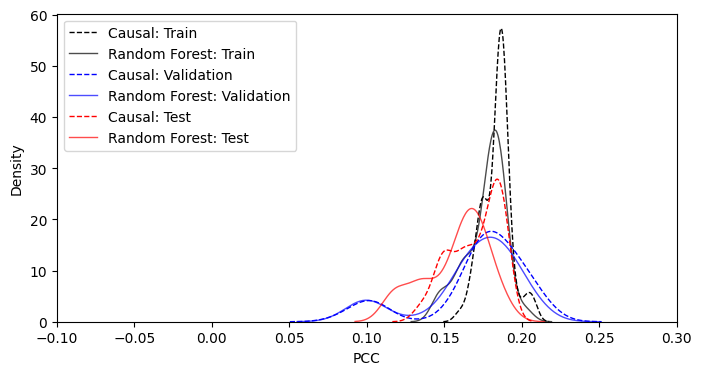

In [61]:
#with load_theme("scientific"):
fig,ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(np.asarray(miss.flatten(pcc_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_train_XAIFS)),c='k',ls='-',lw=1,alpha=0.7,label='Random Forest: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_XAIFS)),c='b',ls='-',lw=1,alpha=0.7,label='Random Forest: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_XAIFS)),c='r',ls='-',lw=1,alpha=0.7,label='Random Forest: Test',ax=ax)
plt.legend(loc=2)
plt.xlabel('PCC')
plt.xlim(-0.1,0.3)
plt.savefig(f'./figures/SHIPSplus_noassum_pcc_randomforest_kfold_{target}.png')

In [62]:
np.asarray(miss.flatten(r2_train_XAIFS)).max(),np.asarray(miss.flatten(r2_valid_XAIFS)).max(),np.asarray(miss.flatten(r2_test_XAIFS)).max()

(0.20327115801746487, 0.2095964165352454, 0.18641043311661432)

In [63]:
np.asarray(miss.flatten(r2_train_XAIFS)).min(),np.asarray(miss.flatten(r2_valid_XAIFS)).min(),np.asarray(miss.flatten(r2_test_XAIFS)).min()

(0.14440233861416474, 0.08354857872870369, 0.11549444716464108)

In [64]:
np.asarray(miss.flatten(r2_train_XAIFS)).mean(),np.asarray(miss.flatten(r2_valid_XAIFS)).mean(),np.asarray(miss.flatten(r2_test_XAIFS)).mean()

(0.17654487299224814, 0.1620992190817013, 0.1553895206594096)

In [65]:
np.asarray(miss.flatten(pcc_train_XAIFS)).max(),np.asarray(miss.flatten(pcc_valid_XAIFS)).max(),np.asarray(miss.flatten(pcc_test_XAIFS)).max()

(0.20327115801746495, 0.21207131435491103, 0.18965174689665287)

In [66]:
np.asarray(miss.flatten(pcc_train_XAIFS)).min(),np.asarray(miss.flatten(pcc_valid_XAIFS)).min(),np.asarray(miss.flatten(pcc_test_XAIFS)).min()

(0.1444023386141648, 0.09314552059808753, 0.11720913024728769)

In [67]:
np.asarray(miss.flatten(pcc_train_XAIFS)).mean(),np.asarray(miss.flatten(pcc_valid_XAIFS)).mean(),np.asarray(miss.flatten(pcc_test_XAIFS)).mean()

(0.1765448729922482, 0.16748963082699472, 0.15725549154726823)

## Boxplot

In [68]:
import pickle

# === Bundle your arrays ===
pccbox_delv24 = {
    'train_noFS': pcc_train_noFS,
    'valid_noFS': pcc_valid_noFS,
    'test_noFS': pcc_test_noFS,

    'train_causalFS': pcc_train_causalFS,
    'valid_causalFS': pcc_valid_causalFS,
    'test_causalFS': pcc_test_causalFS,

    'train_corrFS': pcc_train_corrFS,
    'valid_corrFS': pcc_valid_corrFS,
    'test_corrFS': pcc_test_corrFS,

    'train_XAIFS': pcc_train_XAIFS,
    'valid_XAIFS': pcc_valid_XAIFS,
    'test_XAIFS': pcc_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/pccbox_shipsplus_{target}.pkl', 'wb') as f:
    pickle.dump(pccbox_delv24, f)

print(f"✅ Saved pccbox_shipsplus_{target}.pkl")

✅ Saved pccbox_shipsplus_DELV24.pkl


In [69]:
import pickle

# === Bundle your arrays ===
pccbox_delv24 = {
    'train_noFS': r2_train_noFS,
    'valid_noFS': r2_valid_noFS,
    'test_noFS': r2_test_noFS,

    'train_causalFS': r2_train_causalFS,
    'valid_causalFS': r2_valid_causalFS,
    'test_causalFS': r2_test_causalFS,

    'train_corrFS': r2_train_corrFS,
    'valid_corrFS': r2_valid_corrFS,
    'test_corrFS': r2_test_corrFS,

    'train_XAIFS': r2_train_XAIFS,
    'valid_XAIFS': r2_valid_XAIFS,
    'test_XAIFS': r2_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/r2box_shipsplus_{target}.pkl', 'wb') as f:
    pickle.dump(pccbox_delv24, f)

print(f"✅ Saved r2box_shipsplus_{target}.pkl")

✅ Saved r2box_shipsplus_DELV24.pkl
